# Applied problem: Sequence of operations on images

In [69]:
import glob, os
from dask.distributed import Client
from dask import delayed
import dask
import skimage.io
import skimage.filters
import numpy as np
import matplotlib.pyplot as plt

A very common problem when dealing with image processing, is to have a set of images in a folder and having to apply a time-consuming operation on all of them.

Let's first get the names of all images. There are two types of images in this dataset and we only keep the one where files contain "_w1".

In [16]:
filenames = [x for x in glob.glob('../Data/BBBC006_v1_images_z_16/*.tif') if '_w1' in x ]

In [17]:
filenames

['../Data/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_a13_s1_w11ad93276-a6b4-4f7f-8e83-25d18e01d389.tif',
 '../Data/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_c05_s1_w18e6e71b4-0c88-4220-b35a-ddcfd008b579.tif',
 '../Data/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_a20_s1_w14b594f25-9d99-4809-b5f6-f6bf2f552504.tif',
 '../Data/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_a20_s2_w1e3fe55e4-c574-4f6c-8057-c0ef4b6a984a.tif',
 '../Data/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_a15_s2_w107a10303-4a2c-49d6-9082-62214f0d5478.tif',
 '../Data/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_b22_s2_w1ded24d5c-1f03-425c-bb3f-5ec1b38fe30a.tif',
 '../Data/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_c14_s2_w1699555a8-3e11-4c5f-9644-9c5dc999bcc6.tif',
 '../Data/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_a22_s2_w10d18a616-7dcb-4991-8875-d8aed01f76d5.tif',
 '../Data/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_a24_s2_w1352a2a87-2d9a-42c5-b647-06ef75bce23e.tif',
 '../Data/BBBC006_v1_images_z_16/mcf-

This is not an image processing exercise, but let's have a look at one image to have an idea what we are dealing with:

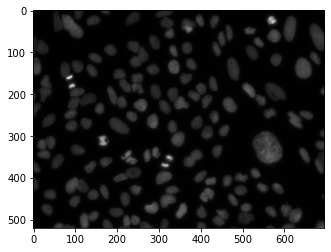

In [26]:
image = skimage.io.imread(filenames[0])
plt.imshow(image, cmap = 'gray')

What we see here are cell nuclei observed by fluorescence microscopy. A very common task with such data is to distinguish, i.e. *segment*, the nuclei so that their properties can be analyzed. To do that each image needs to go through a series of image processing steps. We give here a very simple example where images are noise-filtered, thresholded by intensity and then "objects" labeled and measured.

Dask is not good at parsing filenames so we transform those into absolute paths:

In [33]:
filenames = [os.path.abspath(f) for f in filenames]

We can time this operation for one image:

In [54]:
%%time
image = skimage.io.imread(filenames[0])
image = skimage.filters.median(image, skimage.morphology.disk(5))
thresholded = image > skimage.filters.threshold_otsu(image)
labeled = skimage.morphology.label(thresholded)
area = skimage.measure.regionprops_table(label_image=labeled, properties=('label','area'))
mean_area = np.mean(area['area'])

CPU times: user 380 ms, sys: 6.64 ms, total: 387 ms
Wall time: 381 ms


We can have a look at what we did:

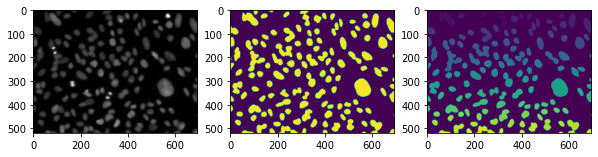

In [35]:
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(thresholded)
ax[2].imshow(labeled)

We have 750 images so, this very simple processing would already take 4min. If we would use much more advanced algorithms and much larger datasets, this can become very slow.

We can now see if we can improve things by parallelizing, using Dask. First we create our client, which by default used all the CPUs on the machine:

In [45]:
client = Client()

In [46]:
client

Client Scheduler: tcp://127.0.0.1:62861 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


Then we can time our routine by looping over the 50 first images:

In [71]:
%%time
all_areas = []
for f in filenames[0:50]:
    image = skimage.io.imread(f)
    image = skimage.filters.median(image, skimage.morphology.disk(5))
    thresholded = image > skimage.filters.threshold_otsu(image)
    labeled = skimage.morphology.label(thresholded)
    area = skimage.measure.regionprops_table(label_image=labeled, properties=('label','area'))
    mean_area = np.mean(area['area'])
    all_areas.append(mean_area)

CPU times: user 18 s, sys: 190 ms, total: 18.2 s
Wall time: 17.7 s


Now we try to parallelize using Dask. We decorate each function *delayed* and run again:

In [88]:
%%time
all_areas2 = []
for f in filenames[0:50]:
    
    image = delayed(skimage.io.imread)(f)
    image = delayed(skimage.filters.median)(image, skimage.morphology.disk(5))
    thresholded = image > delayed(skimage.filters.threshold_otsu)(image)
    labeled = delayed(skimage.morphology.label)(thresholded)
    area = delayed(skimage.measure.regionprops_table)(label_image=labeled, properties=('label','area'))
    mean_area = np.mean(area['area'])
    all_areas2.append(mean_area)

CPU times: user 45.4 ms, sys: 5.7 ms, total: 51.1 ms
Wall time: 50.9 ms


In [89]:
%%time
all_areas3 = dask.compute(all_areas2)

CPU times: user 907 ms, sys: 75.1 ms, total: 982 ms
Wall time: 7.83 s


Instead of having to decorate each part of the routine, we can also create a function that encompassed each step and call that function on all images:

In [90]:
def seg_fun(f):
    image = skimage.io.imread(f)
    image = skimage.filters.median(image, skimage.morphology.disk(5))
    thresholded = image > skimage.filters.threshold_otsu(image)
    labeled = skimage.morphology.label(thresholded)
    area = skimage.measure.regionprops_table(label_image=labeled, properties=('label','area'))
    mean_area = np.mean(area['area'])
    return mean_area

In [91]:
all_areas4 = [delayed(seg_fun)(f) for f in filenames[0:50]]

In [92]:
%%time
all_areas5 = dask.compute(all_areas4)

CPU times: user 519 ms, sys: 56 ms, total: 575 ms
Wall time: 7.56 s


The time is comparable to the first solution. The drawback of that appraoch is that we don't have anymore information on which part of the code is the slowest.

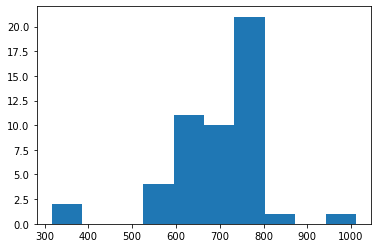

In [96]:
plt.hist(all_areas5[0]);